<a href="https://colab.research.google.com/github/ShreyPandit/Lipschitz/blob/master/CIFAR10_Adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
from tqdm import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, BatchNormalization, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from tqdm import tqdm_notebook as tqdm

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
!pip install tensorflow==1.14.0

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [4]:
batch_size = 256
num_classes = 10
epochs = 20
img_rows, img_cols = 32, 32
lrs=[]

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)        

In [19]:
from keras import backend as K
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
K1 = 0.
K2 = 0.
beta1 = 0.9
beta2 = 0.999

In [20]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1, K2

    Kz = 0.
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size)
    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S 
    
    K1 = beta1 * K1 + (1 - beta1) * K_
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / K1
    print('S =', S, ', K1 =', K1,', K2 =', K2, ', K_ =', K_, ', lr =', lr)
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr

In [21]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])


In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(x_train)

In [24]:
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/5
S = 110.552216 , K1 = 0.029252512156963343 , K2 = 1.3663832796737564e-06 , K_ = 0.2925251215696335 , lr = 0.0399631996537338
Epoch 0 LR = 0.0399631996537338
196/195 [==============================] - 269s 1s/step - loss: 2.0192 - accuracy: 0.2526 - val_loss: 1.7789 - val_accuracy: 0.3239
Epoch 2/5
S = 165.37256 , K1 = 0.046065022855997076 , K2 = 3.408958736923527e-06 , K_ = 0.19737761914730073 , lr = 0.04008326616320243
Epoch 1 LR = 0.04008326616320243
196/195 [==============================] - 267s 1s/step - loss: 1.7029 - accuracy: 0.3648 - val_loss: 1.8754 - val_accuracy: 0.3663
Epoch 3/5
S = 448.991 , K1 = 0.07078100351393221 , K2 = 8.95490750256263e-06 , K_ = 0.2932248294353485 , lr = 0.04227935460020362
Epoch 2 LR = 0.04227935460020362
196/195 [==============================] - 270s 1s/step - loss: 1.5560 - accuracy: 0.4278 - val_loss: 1.3697 - val_accuracy: 0.5054
Epoch 4/5
S = 3493.8833 , K1 = 0.09210741348177193 , K2 = 5.21290195145061e-05 , K_ = 0.2840451031923294 ,

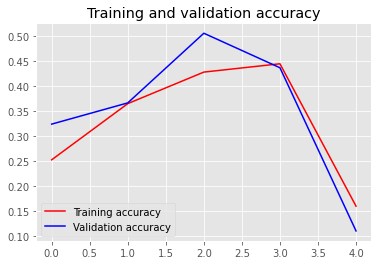

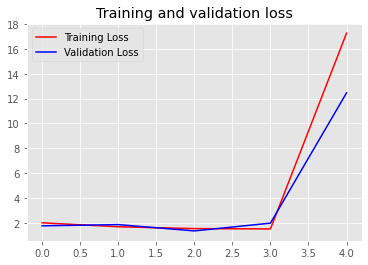

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()